In [49]:
pip install scikit-misc

Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np
from plotnine import *
import patsy
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import statsmodels.formula.api as smf
from py_helper_functions import *

In [101]:
data=pd.read_csv('cs_bisnode_panel.csv')

In [102]:
to_filter=data.isna().sum()
to_filter[to_filter > 0]

COGS                 269572
amort                  8040
curr_assets             131
curr_liab               131
extra_exp             18529
extra_inc             18529
extra_profit_loss     17203
finished_prod        270344
fixed_assets            131
inc_bef_tax            7437
intang_assets           140
inventories             131
liq_assets              131
material_exp           8040
net_dom_sales        269572
net_exp_sales        269572
personnel_exp          8040
profit_loss_year       9884
sales                  7437
share_eq                131
subscribed_cap          131
tang_assets            1470
wages                269846
D                    287829
founded_year          56457
exit_year            248970
ceo_count             56427
foreign               56427
female                56427
birth_year           111818
inoffice_days         56427
gender                56427
origin                56427
nace_main              1038
ind2                   1038
ind                 

In [103]:
#drop variables with too many NaN
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages','D'])

In [104]:
data = data.query('year !=2016')

In [105]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = data.set_index(['year','comp_id']).unstack(fill_value ='toReplace').stack().reset_index()
data = data.replace('toReplace',np.nan) #only way I could define it as NaN

In [106]:
data['year']

0         2005
1         2005
2         2005
3         2005
4         2005
          ... 
510527    2015
510528    2015
510529    2015
510530    2015
510531    2015
Name: year, Length: 510532, dtype: int64

In [107]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

In [108]:
#define growth as quarter growth in a year
data['growth'] = ((data['sales'] / data.groupby('comp_id')['sales'].shift(1)) >= 1.25).astype(int)


In [109]:
data['fast_growth'] = ((data['status_alive'] == 1) & 
                       (data.groupby('comp_id')['status_alive'].shift(1) == 1) &
                       (data['growth'] == 1)).astype(int)

In [110]:
data.fast_growth.describe()

count    510532.000000
mean          0.103880
std           0.305105
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fast_growth, dtype: float64

In [111]:
data['sales'].describe()

count    2.706490e+05
mean     4.877188e+05
std      3.871007e+06
min     -1.472559e+07
25%      4.685185e+03
50%      3.028889e+04
75%      1.109185e+05
max      1.110294e+08
Name: sales, dtype: float64

In [112]:
data = data.query('year <= 2014')

In [113]:
data['sales']=np.where(data['sales'] < 0, 1, data['sales'])#has to be outside of assin()
data = data.assign(
    ln_sales = np.where(data['sales'] > 0 , np.log(data['sales']), (np.where(data['sales'].isna(),np.nan,0))), #NaN remain NaN
    sales_mil=data['sales']/1000000,
    sales_mil_log = np.where(data['sales'] > 0, np.log(data['sales']/1000000), (np.where(data['sales'].isna(),np.nan,0)))
  )

C:\Users\99450\anaconda\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
C:\Users\99450\anaconda\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log


In [114]:
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)

In [115]:
# replace w 0 for new firms + add dummy to capture it
data['age']=np.where(data['year']-data['founded_year'] < 0, 0, data['year']-data['founded_year'])
data['new']=np.where(((data['age']<=1)|(data['balsheet_notfullyear']==1)),1,(np.where(data['age'].isna(),np.nan,0))) 
data['d1_sales_mil_log']=np.where(data['new']==1 , 0, np.where(data['new'].isna(),np.nan,data['d1_sales_mil_log']))
data['new']=np.where(data['d1_sales_mil_log'].isna(),1,data['new'] )
data['d1_sales_mil_log']=np.where(data['d1_sales_mil_log'].isna(),0,data['d1_sales_mil_log'])

In [116]:
data['new'].describe()

count    464120.000000
mean          0.685790
std           0.464201
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

In [117]:
# look at cross section
data=data.query('year==2014 & status_alive == 1')
# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales_mil<=10 & sales_mil>=0.001')

In [118]:
data['year']

417709    2014
417710    2014
417715    2014
417716    2014
417717    2014
          ... 
464110    2014
464112    2014
464114    2014
464115    2014
464118    2014
Name: year, Length: 21290, dtype: int64

In [119]:
# change some industry category codes
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [120]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       54
26.0     1037
27.0      632
28.0     1901
29.0      275
30.0      170
32.0      126
33.0     1961
35.0        1
40.0      209
55.0     2337
56.0    12342
60.0      240
99.0        5
Name: comp_id, dtype: int64

In [121]:
# Firm characteristics
data['age2'] = data['age']**2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [122]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21271
1.0        7
Name: comp_id, dtype: int64

In [123]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [124]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.127800e+04
mean     3.068029e+05
std      2.914499e+06
min      0.000000e+00
25%      8.888889e+03
50%      3.007407e+04
75%      1.168287e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

In [125]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [126]:
# divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [127]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +'_bs']] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +'_bs'])

In [128]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [129]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [130]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [131]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [132]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [133]:
data['labor_avg'].describe()

count    16712.000000
mean         0.680562
std          1.700423
min          0.083333
25%          0.125000
50%          0.250000
75%          0.597222
max         64.583336
Name: labor_avg, dtype: float64

In [134]:
data['labor_avg_mod'].describe()

count    21290.000000
mean         0.680562
std          1.506540
min          0.083333
25%          0.166667
50%          0.395833
75%          0.680562
max         64.583336
Name: labor_avg_mod, dtype: float64

In [135]:
data = data.drop(['labor_avg'], axis=1)

In [136]:
########################################################################
 # sales 
########################################################################
data['sales_mil_log_sq'] = data['sales_mil_log']**2

In [137]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['f_fast_growth'] = data['fast_growth'].astype("category")
data['f_fast_growth'] = data['f_fast_growth'].cat.rename_categories(['no_fast_growth', 'growth'])

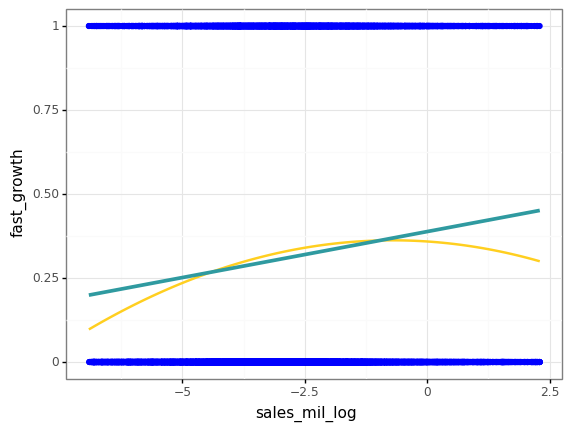

<ggplot: (147649962189)>

In [138]:
ggplot(data, aes(x = "sales_mil_log", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color=color[3], se = False) + geom_smooth(color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="sales_mil_log", y="fast_growth"
) + theme_bw()

In [139]:
# Linear regressions
ols_s = smf.ols('fast_growth ~ sales_mil_log + sales_mil_log_sq', data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     150.8
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           9.19e-66
Time:                        20:08:09   Log-Likelihood:                -13619.
No. Observations:               21290   AIC:                         2.724e+04
Df Residuals:                   21287   BIC:                         2.727e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3587      0.007  

C:\Users\99450\anaconda\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 14763 rows containing missing values.


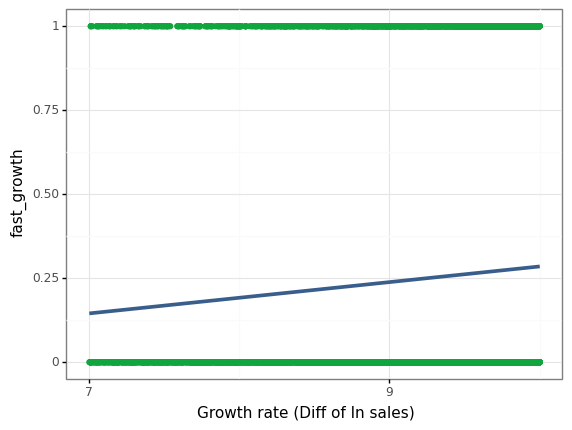

<ggplot: (147676556370)>

In [140]:
ggplot(data, aes(x = 'ln_sales', y = 'fast_growth')) + geom_point(
    color=color[1]) + geom_smooth(color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln sales)', y='fast_growth') + scale_x_continuous(
    limits=(7, 10), breaks = seq(7, 12, by = 2)
) + theme_bw() 

In [141]:
# generate variables ---------------------------------------------------

data['flag_low_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] < -1.5, 1, 0)
data['flag_high_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] > 1.5, 1, 0)
data['d1_sales_mil_log_mod'] = np.where(data['d1_sales_mil_log'] < -1.5, -1.5, 
                                        np.where(data['d1_sales_mil_log'] > 1.5, 1.5, data['d1_sales_mil_log']))
data['d1_sales_mil_log_mod_sq'] = data['d1_sales_mil_log_mod']**2

In [142]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [143]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    19511.000000
mean         9.670442
std          7.406139
min          0.000000
25%          3.000000
50%          8.000000
75%         16.000000
max         63.000000
Name: age, dtype: float64

In [144]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [145]:
# show the columns of missing value
to_filter=data.isna().sum()
to_filter[to_filter > 0].index

Index(['exit_year', 'birth_year', 'exit_date'], dtype='object')

In [47]:
#I didnt like this result so I skip it

#ggplot(data, aes(x = 'd1_sales_mil_log', y = 'fast_growth')) + geom_point(
#    size = 0.1, color = color[1]) + geom_smooth( color = color[0], se = False, size=1.5, span=0.9) + labs(
#    x='Growth rate (Diff of ln sales)', y='Growth') + scale_x_continuous(
#    limits=(-1.5, 1.5), breaks = seq(-1.5, 1.5, by = 0.5)
#) + theme_bw() 

In [146]:
data.to_csv('cs_bisnode_cleaned.csv')